# Plan



Generate some low dimensional dynamics
Then add space on top of that




In [1]:
#%matplotlib notebook
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from jax import grad
seaborn.set(font_scale=1.5,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append("/Users/yves/Documents/Code/mec_ephys/packages/")

In [3]:
from mecll import dynamics
from mecll.dynamics import predict_all, get_basis_tensor, grad_wrapper, caley_transform, get_spatial_tuning

In [4]:
#np.random.seed(99)
x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=1.)

#np.random.seed(99)
sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2)
act_matrix, act_matrix2, space_order2, space_order2_inv = sim_res

ValueError: too many values to unpack (expected 4)

In [5]:
act_matrix2 = act_matrix2[space_order2_inv]

NameError: name 'act_matrix2' is not defined

In [ ]:
n_neurons = act_matrix.shape[1]

In [ ]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# Run with jax

In [12]:
REMOVE_SPACE = False

In [13]:
if REMOVE_SPACE:
    spatial_response = (act_matrix + act_matrix2[space_order2_inv])/2.
    act_matrix2 = act_matrix2 - spatial_response[space_order2]
    act_matrix = act_matrix - spatial_response

In [14]:
#grad_predict_all = grad(predict_all)

In [15]:
from sklearn.decomposition import PCA

In [17]:
pca_dim = 5
pca = PCA(n_components=pca_dim)


pca.fit(np.vstack([act_matrix,act_matrix2]))
pca_activity = pca.transform(act_matrix)
pca_activity2 = pca.transform(act_matrix2)

In [18]:
n_params = int(pca_dim*(pca_dim-1)/2)
basis_tensor_inf = get_basis_tensor(pca_dim)

params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (pca_activity,pca_dim,basis_tensor_inf),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

Desired error not necessarily achieved due to precision loss.


In [19]:
o = np.random.permutation(np.arange(9))
np.allclose(act_matrix[o][:,1],act_matrix[:,1][o])

True

In [20]:
print(res.fun,res.message)

10.171995 Desired error not necessarily achieved due to precision loss.


In [21]:
out = res.x
#out = np.random.normal(size=(n_params))# + np.eye(dim)

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [22]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity.T).T)

In [23]:
#predicted_neural_activity = pca.inverse_transform(pca_activity)

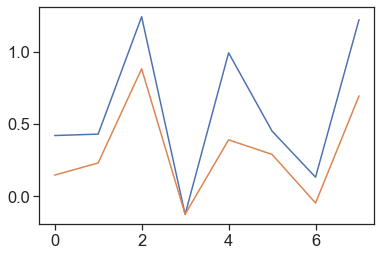

In [24]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_][:-1])
plt.plot(act_matrix[:,ix_][1:])

In [25]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
    
print(np.mean(cc))

0.9379751526213645


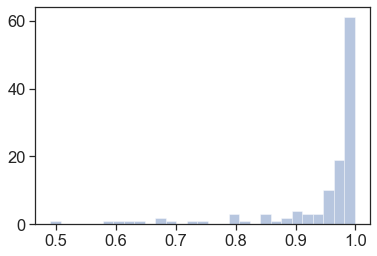

In [26]:
seaborn.distplot(cc,kde=0)

## Now look at the held out task

In [27]:

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,pca_dim)

In [28]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity2.T).T)

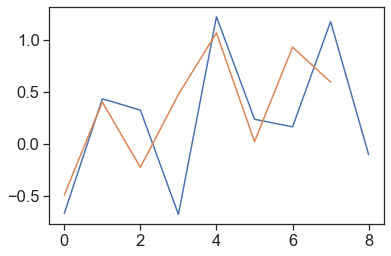

In [29]:
ix_ = 0
plt.plot(predicted_neural_activity[:,ix_])
plt.plot(act_matrix2[:,ix_][1:])

In [30]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix2[:,i][1:],predicted_neural_activity[:,i][:-1])[0,1])
print(np.mean(cc))

0.8208241708612033


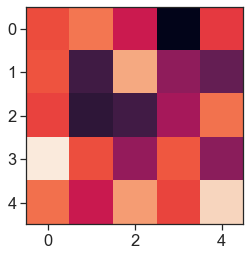

In [31]:
plt.imshow(A)

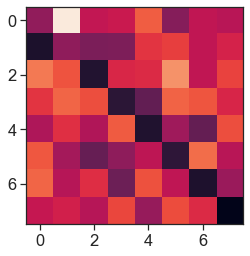

In [28]:
plt.imshow(Ainf)

# Now run actual clean test

In [4]:
def evaluate_cc(activity,pred):
    n_neurons = activity.shape[1]
    true_cc = []
    #print(activity[:,0])

    for i in range(n_neurons):
        true_cc.append(np.corrcoef(activity[:,i][1:],pred[:,i][:-1])[0,1])

    true_cc = np.nanmean(true_cc)
    return np.nanmean(true_cc)

In [5]:
def fit_data(neural_activity1,neural_activity2,pca_activity1,pca_activity2,pca,NFITS=5,NSHUFF=2000):
    pca_dim = pca_activity.shape[1]
    fit_params = []
    fit_quality = []
    for _ in range(NFITS):
        n_params = int(pca_dim*(pca_dim-1)/2)
        basis_tensor_inf = get_basis_tensor(pca_dim)

        params = np.random.normal(size=(n_params))# + np.eye(dim)
        res = op.minimize(predict_all,
                   params,
                   (pca_activity1,pca_dim,basis_tensor_inf),
                   jac=grad_wrapper,
                   method='BFGS'
                   )
        out = res.x
        #out = np.random.normal(size=(n_params))# + np.eye(dim)

        skewM = np.einsum('i...,i...',out,basis_tensor_inf)
        Ainf = caley_transform(skewM,pca_dim)
        #print(res.message)

        predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity1.T).T)
        fit_params.append(out.copy())
        fit_quality.append(evaluate_cc(neural_activity1,predicted_neural_activity))
    params = fit_params[np.argmax(fit_quality)]
    print(fit_quality)
    
    predicted_neural_activity2 = pca.inverse_transform((Ainf@pca_activity2.T).T)
    res = evaluate_cc(neural_activity2,predicted_neural_activity2)
    shuffle_res = []
    print(res)
    
    r9 = np.arange(9)

    for _ in range(NSHUFF):
        
        perm_order = np.random.permutation(r9)
        predicted_neural_activity2_shuff = pca.inverse_transform((Ainf@pca_activity2[perm_order].T).T)

        shf_res = evaluate_cc(neural_activity2[perm_order],predicted_neural_activity2_shuff)
        shuffle_res.append(shf_res)
    return res, shuffle_res
    

In [18]:
#np.random.seed(99)
x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=.7)

#np.random.seed(99)
sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2,frac_space=1,noise_scale=0)
act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
act_matrix2 = act_matrix2[task_order2_inv]

In [19]:
pca_dim = 8
pca = PCA(n_components=pca_dim)


pca.fit(np.vstack([act_matrix,act_matrix2]))
pca_activity = pca.transform(act_matrix)
pca_activity2 = pca.transform(act_matrix2)

In [20]:
res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=5,NSHUFF=100)

[0.819348941576131, 0.8193535491262722, 0.6181521031428839, 0.6181510638492844, 0.8193908252645402]
-0.13640582098861448


In [43]:
real_res = res[0]
shuffle_res = res[1]

In [24]:
all_res_only_space = []
for _ in range(8):

    x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=.7)

    #np.random.seed(99)
    sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2,frac_space=1,noise_scale=0)
    act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
    act_matrix2 = act_matrix2[task_order2_inv]    
    
    pca_dim = 8
    pca = PCA(n_components=pca_dim)


    pca.fit(np.vstack([act_matrix,act_matrix2]))
    pca_activity = pca.transform(act_matrix)
    pca_activity2 = pca.transform(act_matrix2)    
    res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=5,NSHUFF=100)
    all_res_only_space.append(res)

[0.8422710231592234, 0.7786541528611395, 0.8421931337077277, 0.6514745437583568, 0.8422708525739278]
-0.31863720732772793
[0.7647344874663086, 0.6161153256691523, 0.7482294450682758, 0.7303247588314437, 0.6178884099574842]
0.03134983139822781
[0.6669777489057626, 0.7639281890839084, 0.8042457402906104, 0.7544902471039774, 0.7775872425794579]
0.1536279711932865
[0.7788106650764076, 0.7306862231631516, 0.8288928377793745, 0.5973168746549881, 0.8288949067366661]
0.2173455538857639
[0.8130403850016619, 0.6077934839546738, 0.8130259133175286, 0.6003724422194919, 0.8130380296614977]
0.1689132713557947
[0.8267369140866172, 0.7390237548024637, 0.8267652015549257, 0.6237672537322668, 0.7496023227184899]
0.060802045362255204
[0.8105613856111451, 0.7112019862341034, 0.8105406175207712, 0.5741130771973123, 0.8106104352811705]
-0.0022798538839935776
[0.8360032424695266, 0.7834438621973716, 0.7707068615111294, 0.8360106239872778, 0.8360291718728955]
0.16731889652595555


In [25]:
all_res_with_space = []
for _ in range(8):

    x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=.7)

    #np.random.seed(99)
    sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=x2,frac_space=None,noise_scale=0)
    act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
    act_matrix2 = act_matrix2[task_order2_inv]    
    
    pca_dim = 8
    pca = PCA(n_components=pca_dim)


    pca.fit(np.vstack([act_matrix,act_matrix2]))
    pca_activity = pca.transform(act_matrix)
    pca_activity2 = pca.transform(act_matrix2)    
    res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=5,NSHUFF=100)
    all_res_with_space.append(res)

[0.8098135892999437, 0.8095128172266014, 0.8080472835193332, 0.8012124985415603, 0.8075771944321171]
0.59729441165493
[0.6308088690231332, 0.6306977918724006, 0.7097928179737216, 0.6888953134546566, 0.6886095430544125]
0.5160248679746946
[0.7822185692875017, 0.7469977860573116, 0.7632267109801134, 0.7315728644520355, 0.8431462959728321]
0.336812336649562
[0.7749755575440352, 0.7657556831947802, 0.7724203261822111, 0.7590501750630436, 0.736025511438932]
0.5075610710859012
[0.9024115633747221, 0.8537872952292538, 0.9017927875919227, 0.8884552234980231, 0.9021235687938973]
0.7420509497446887
[0.703781002457067, 0.818544953312074, 0.8161280312230825, 0.6779216466857878, 0.6925297658036396]
0.2957632683511617
[0.685960757124555, 0.5413615089387658, 0.4742157479276339, 0.6302089825019567, 0.5197195448519378]
-0.027165728846548973
[0.8924323685808672, 0.8086861164015615, 0.8488269846038018, 0.8488005739861103, 0.8586281393791213]
0.033173566360357204


In [26]:
real_res = [i[0] for i in  all_res_with_space]
shuffle_res = [i[1] for i in  all_res_with_space]

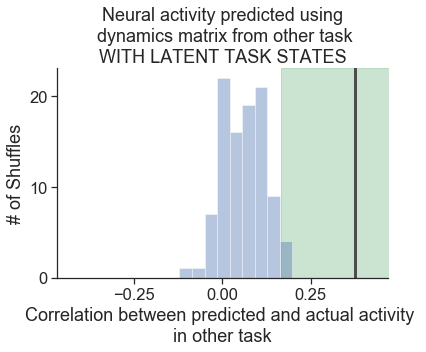

In [71]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task\nWITH LATENT TASK STATES")

real_res = [i[0] for i in  all_res_with_space]
shuffle_res = [i[1] for i in  all_res_with_space]

seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota

mx = np.max([np.mean(real_res),np.max(np.abs(np.nanmean(np.array(shuffle_res),axis=0)))])*1.25
seaborn.despine()
plt.xlim(-mx,mx)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

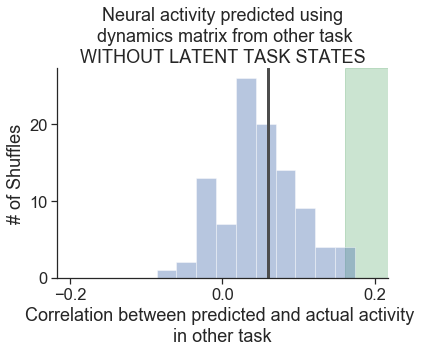

In [72]:
real_res = [i[0] for i in  all_res_only_space]
shuffle_res = [i[1] for i in  all_res_only_space]
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task\nWITHOUT LATENT TASK STATES")
seaborn.distplot(np.nanmean(np.array(shuffle_res),axis=0),kde=0)
plt.axvline(x=np.mean(real_res),color='.3',linewidth=3)
#plt.annota

mx = np.max([np.mean(real_res),np.max(np.abs(np.nanmean(np.array(shuffle_res),axis=0)))])*1.25
seaborn.despine()
plt.xlim(-mx,mx)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(np.nanmean(np.array(shuffle_res),axis=0),97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

In [55]:
[real_res,np.max(np.nanmean(np.array(shuffle_res),axis=0))]

[[0.59729441165493,
  0.5160248679746946,
  0.336812336649562,
  0.5075610710859012,
  0.7420509497446887,
  0.2957632683511617,
  -0.027165728846548973,
  0.033173566360357204],
 0.1978533194235353]

ValueError: color kwarg must have one color per data set. 2000 data sets and 1 colors were provided

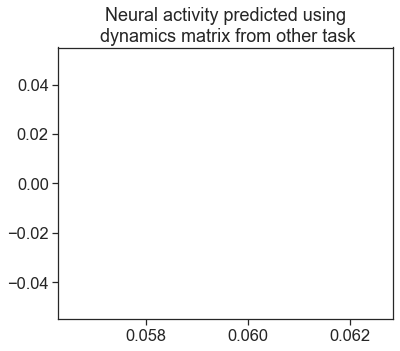

In [52]:
plt.figure(figsize=(6,5))
plt.title("Neural activity predicted using\n dynamics matrix from other task")
seaborn.distplot(shuffle_res,kde=0)
plt.axvline(x=real_res,color='.3',linewidth=3)
#plt.annota
seaborn.despine()
#plt.xlim(-1,1)
yl = plt.gca().get_ylim()
plt.fill_between([np.percentile(shuffle_res,97.5),1],[yl[1]]*2,color='g',alpha=.3)
plt.ylim(yl)
plt.xlabel("Correlation between predicted and actual activity \nin other task")
plt.ylabel("# of Shuffles")
plt.locator_params(nbins=3)
plt.tight_layout()

In [ ]:
all_res_only_space = []
for _ in range(8):
    #np.random.seed(99)
    x1,x2,A = dynamics.simulate_dynamics(dim=5,frac_noise_dynamics=1.,)

    #np.random.seed(99)
    sim_res = dynamics.simulate_activity(n_neurons=120,x=x1,x_2=np.random.normal(size=x2.shape),frac_space=None)
    act_matrix, act_matrix2, space_order2, space_order2_inv, task_order2, task_order2_inv = sim_res
    act_matrix2 = act_matrix2[task_order2_inv]
    
    pca_dim = 8
    pca = PCA(n_components=pca_dim)

    pca.fit(np.vstack([act_matrix,act_matrix2]))
    pca_activity = pca.transform(act_matrix)
    pca_activity2 = pca.transform(act_matrix2)
    
    res = fit_data(act_matrix,act_matrix2,pca_activity,pca_activity2,pca,NFITS=5,NSHUFF=2000)
    all_res_only_space.append(res)